In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import sys
sys.path.append('../../src/generic')
import csv
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
from sklearn.metrics import log_loss

In [3]:
from dataset.amazon_reviews_clf_dataset import AmazonClfDataset
from results.process_results import ResultProcessor

In [4]:
main_result_dir = "/data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf"

In [5]:
test_cols = ["test_{}_accuracy".format(i) for i in range(5)]

In [6]:
ce_cols = ["eval_loss", "test_loss"]

## Predict Test Distr Baseline

I.e., predict prob(class) = fraction of class in test data

In [7]:
data_dir = "/data/ddmg/redditlanguagemodeling/data/AmazonReviews/data"

In [8]:
data_df = pd.read_csv(os.path.join(data_dir, 'amazon_v2.0/reviews.csv'),
                      dtype={'reviewerID':str, 'asin':str, 'reviewTime':str,'unixReviewTime':int,
                             'reviewText':str,'summary':str,'verified':bool,'category':str, 'reviewYear':int},
                      keep_default_na=False, na_values=[], quoting=csv.QUOTE_NONNUMERIC)

In [9]:
split_df = pd.read_csv(os.path.join(data_dir, 'amazon_v2.0', 'splits', 'my_user_split.csv'))

In [10]:
# get select people
select_file = "/data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/selected_people.txt"
with open(select_file, 'r') as f:
    people = f.read().splitlines()

In [11]:
data_df["split"] = split_df["split"]

In [12]:
select_df = data_df[data_df["reviewerID"].isin(people)]

In [13]:
len(select_df)

140326

In [14]:
test_df = select_df[split_df["split"] == 2]

<ipython-input-14-0e99ae5568ce>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = select_df[split_df["split"] == 2]


In [49]:
train_df = select_df[split_df["split"] == 0]

<ipython-input-49-889f06942d9b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = select_df[split_df["split"] == 0]


In [50]:
len(train_df)

43555

In [15]:
len(test_df)

14687

In [16]:
def get_val_counts(x, val):
    return sum(x == val)

In [17]:
score_df = test_df[["reviewerID", "overall"]]
score_df.head(5)

,reviewerID,overall
260,A1AEPMPA12GUJ7,4.0
1705,A4UWNRY0WWECK,5.0
1837,A23URR08HKOXIN,5.0
3229,A2PGJP6GV2ZC02,5.0
6168,A67ZXSOC2XH4O,4.0


In [51]:
train_score_df = train_df[["reviewerID", "overall"]]

In [18]:
def count_1(x):
    return sum(x == 1)

count_1.__name__ = "count_1"

def count_2(x):
    return sum(x == 2)

count_2.__name__ = "count_2"

def count_3(x):
    return sum(x == 3)

count_3.__name__ = "count_3"

def count_4(x):
    return sum(x == 4)

count_4.__name__ = "count_4"

def count_5(x):
    return sum(x == 5)

count_5.__name__ = "count_5"

In [19]:
count_fns = [count_1, count_2, count_3, count_4, count_5]

In [20]:
test_dist_by_user = score_df.groupby(["reviewerID"]).agg(count_fns)
test_dist_by_user

overall                                
               count_1 count_2 count_3 count_4 count_5
reviewerID                                            
A101S5PLO0VRHQ     2.0    11.0    11.0     5.0     6.0
A10E0V7PGY34UZ     0.0     0.0     0.0     1.0    14.0
A10O7THJ2O20AG     1.0     0.0     1.0     1.0    12.0
A11P853U6FIKAM     1.0     0.0    10.0    22.0    24.0
A12O5K3EQ4MC7Z     0.0     0.0    10.0    21.0    20.0
...                ...     ...     ...     ...     ...
AYT4FJYVCHYLE      0.0     1.0     2.0     5.0     7.0
AYVW3O6W8S5S4      0.0     1.0     2.0     8.0     4.0
AZD488SA9QMYF      0.0     0.0     0.0     1.0    14.0
AZJ4DFLH9O4FZ      0.0     0.0     4.0     6.0     5.0
AZZV9PDNMCOZW      1.0     2.0     2.0     2.0     8.0

[500 rows x 5 columns]

In [56]:
train_dist_by_user = train_score_df.groupby(["reviewerID"]).agg(count_fns)
train_dist_by_user

overall                                
               count_1 count_2 count_3 count_4 count_5
reviewerID                                            
A101S5PLO0VRHQ     5.0    29.0    20.0    24.0    25.0
A10E0V7PGY34UZ     0.0     0.0     0.0     4.0    41.0
A10O7THJ2O20AG     1.0     0.0     1.0     0.0    43.0
A11P853U6FIKAM     0.0     5.0    18.0    61.0    82.0
A12O5K3EQ4MC7Z     1.0     2.0    24.0    61.0    61.0
...                ...     ...     ...     ...     ...
AYT4FJYVCHYLE      0.0     2.0     9.0    24.0    10.0
AYVW3O6W8S5S4      0.0     0.0     8.0    23.0    14.0
AZD488SA9QMYF      0.0     0.0     0.0     3.0    42.0
AZJ4DFLH9O4FZ      0.0     0.0     3.0    15.0    27.0
AZZV9PDNMCOZW      3.0     0.0     7.0    16.0    19.0

[500 rows x 5 columns]

In [58]:
# for each user predict test probs
users = []
perfs = []
for user, row in test_dist_by_user.iterrows():
    user_gt = score_df[score_df["reviewerID"] == user]["overall"].values
    score_counts = np.array([row["overall", "count_{}".format(i + 1)] for i in range(5)])
    norm_score_counts = np.expand_dims(score_counts / sum(score_counts), axis=0)
    preds = np.repeat(norm_score_counts, len(user_gt), axis=0)
    loss = log_loss(user_gt, preds, labels=np.arange(5) + 1)
    users.append(user)
    perfs.append(loss)

In [33]:
baseline_prob_df = pd.DataFrame({"reviewerID": users, "perf": perfs})

In [34]:
baseline_prob_df

,reviewerID,perf
0,A101S5PLO0VRHQ,1.471413
1,A10E0V7PGY34UZ,0.244930
2,A10O7THJ2O20AG,0.720125
3,A11P853U6FIKAM,1.107927
4,A12O5K3EQ4MC7Z,1.051915
...,...,...
495,AYT4FJYVCHYLE,1.171060
496,AYVW3O6W8S5S4,1.136917
497,AZD488SA9QMYF,0.244930
498,AZJ4DFLH9O4FZ,1.085189


In [35]:
print(baseline_prob_df.mean())
print(baseline_prob_df.std())

perf    0.790699
dtype: float64
perf    0.388399
dtype: float64


In [43]:
print(baseline_prob_df.quantile(q=[.2, .4, .6, .8, 1]))

         perf
0.2  0.481677
0.4  0.696330
0.6  0.927617
0.8  1.136917
1.0  1.586785


In [57]:
# for each user predict train_probs
users2 = []
perfs2 = []
for user, row in train_dist_by_user.iterrows():
    user_gt = score_df[score_df["reviewerID"] == user]["overall"].values
    score_counts = np.array([row["overall", "count_{}".format(i + 1)] for i in range(5)])
    norm_score_counts = np.expand_dims(score_counts / sum(score_counts), axis=0)
    preds = np.repeat(norm_score_counts, len(user_gt), axis=0)
    loss = log_loss(user_gt, preds, labels=np.arange(5) + 1)
    users2.append(user)
    perfs2.append(loss)

In [59]:
baseline_prob_df2 = pd.DataFrame({"reviewerID": users2, "perf": perfs2})

In [60]:
baseline_prob_df2

,reviewerID,perf
0,A101S5PLO0VRHQ,1.537137
1,A10E0V7PGY34UZ,0.248242
2,A10O7THJ2O20AG,2.846510
3,A11P853U6FIKAM,1.679051
4,A12O5K3EQ4MC7Z,1.075978
...,...,...
495,AYT4FJYVCHYLE,1.333598
496,AYVW3O6W8S5S4,3.202199
497,AZD488SA9QMYF,0.244930
498,AZJ4DFLH9O4FZ,1.331867


In [61]:
print(baseline_prob_df2.mean())
print(baseline_prob_df2.std())

perf    1.156198
dtype: float64
perf    0.966114
dtype: float64


In [62]:
print(baseline_prob_df2.quantile(q=[.2, .4, .6, .8, 1]))

         perf
0.2  0.527940
0.4  0.840569
0.6  1.094182
0.8  1.468325
1.0  7.833139


## Global Model

In [44]:
base_result_dir = os.path.join(main_result_dir, "from_embeds", "eval_train_all_my_user_split_from_my_user_split_clf_embeddings")
levels = ["user", "seed"]
global_results = ResultProcessor(base_result_dir, levels, verbose=True)

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings: Found results for 500 users
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1JY6HFCL4PZI4: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A11P853U6FIKAM: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A2AKH66IWM5O5: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A2BAAKZHSUGCDP: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embe

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/AW3VZ5O895LRK: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/AD2QRU9ZXBQZ1: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A3OBJGGKN1KREP: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A3P89EMO989X9D: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A2QS3RG1ZA9F73: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/c

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A28SW1AQI0RADX: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A2WG33SBOT901X: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1TPW86OHXTXFC: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A3G53293E5J9PZ: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/ANT80RNKZGHFJ: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1YFB1OF0XKJOD: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A37SZWL3R0LEQ3: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A3QFDDODG2X2HL: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1FYGMRKYQWZRI: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A2IP8CT8CHOVPB: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A3STJPJ06CMRVF: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1IVNZD0A4AMAG: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/AUUFW7PTUHLT: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1WCZ1EBA7KN0U: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A384RYAHGEPLJ8: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/c

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A24BB7ZQSVFD92: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A16ZTSR8M5J5G2: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A3NLJZI5NEOT0K: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A3O37N1EDT5RCN: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A39JNWWX6LI6VE: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A3A1HHLJZL97DP: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A24QVHHT8CFPID: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A2NU0FM3MS15EB: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/AY17DZYGNYJ0L: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1ACIK34MC3R7W: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A13QONG1RD57UW: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1AXSZYFRA93RC: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A14VYB264WN1PM: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/AHLVLW2TZX1LA: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/AQR8MEGW6A81G: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/c

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A3GQ7EGAQY2UYX: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1GCZ07XRJX858: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A35KF1CYL39HPQ: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1NRBV4S9HENY7: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1JRAPFDUA02P1: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A2H19TYZFH5RGY: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1DJW1R7070SZG: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/AT1J73L759KWF: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1R6DKN9YQ2YU1: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1AM3VH47V9VLN: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A3G0123D15ORSW: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A1YHXJKXJCUNBY: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A39IY0JU5JI69G: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A6VXZ1EEPRTLV: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/eval_train_all_my_user_split_from_my_user_split_clf_embeddings/A3HV2YMF920P0F: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/

In [72]:
# look at training progress
base_result_dir = os.path.join(main_result_dir, "from_embeds", "train_all_my_user_split_from_my_user_split_clf_embeddings")
levels = ["seed"]
global_results2 = ResultProcessor(base_result_dir, levels, verbose=True)

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/train_all_my_user_split_from_my_user_split_clf_embeddings: Found results for 3 seeds


In [73]:
global_results2.train_hist_df

,step,data,loss,seed
0,500,train,0.762800,42
1,1000,train,0.683900,42
2,1500,train,0.658900,42
3,2000,train,0.666200,42
4,2500,train,0.665000,42
...,...,...,...,...
115,28000,val,0.688064,43
116,28500,val,0.684583,43
117,29000,val,0.683748,43
118,29500,val,0.685886,43


<AxesSubplot:xlabel='step', ylabel='loss'>

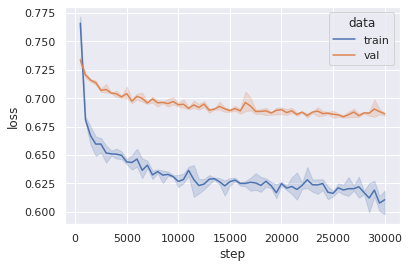

In [74]:
# training loss seems to still be going down but validation loss seems to have plateaued
sns.lineplot(data=global_results2.train_hist_df, x="step", y="loss", hue="data")

In [77]:
user_results_global = global_results.results_df.groupby(["user"]).agg(["mean", "std"])[["test_loss", "test_accuracy"]]
user_results_global

test_loss           test_accuracy          
                    mean       std          mean       std
user                                                      
A101S5PLO0VRHQ  1.071330  0.053468      0.485714  0.049487
A10E0V7PGY34UZ  0.335533  0.036228      0.933333  0.000000
A10O7THJ2O20AG  1.316525  0.096827      0.555556  0.076980
A11P853U6FIKAM  0.931869  0.022386      0.479532  0.010129
A12O5K3EQ4MC7Z  0.710485  0.008239      0.725490  0.033962
...                  ...       ...           ...       ...
AYT4FJYVCHYLE   0.610010  0.021436      0.733333  0.000000
AYVW3O6W8S5S4   1.623604  0.060454      0.333333  0.000000
AZD488SA9QMYF   0.228966  0.029288      0.955556  0.038490
AZJ4DFLH9O4FZ   0.692731  0.033360      0.644444  0.038490
AZZV9PDNMCOZW   1.107140  0.110412      0.533333  0.115470

[500 rows x 4 columns]

In [81]:
user_results_global.mean()

test_loss      mean    0.715159
               std     0.041007
test_accuracy  mean    0.694542
               std     0.035038
dtype: float64

In [82]:
user_results_global.std()

test_loss      mean    0.368251
               std     0.029370
test_accuracy  mean    0.177386
               std     0.031738
dtype: float64

In [83]:
user_results_global.quantile(q=[.2, .4, .6, .8, 1])

test_loss           test_accuracy          
         mean       std          mean       std
0.2  0.399060  0.018027      0.536492  0.000000
0.4  0.591618  0.028111      0.659969  0.027475
0.6  0.767468  0.040235      0.755556  0.038490
0.8  0.997398  0.060974      0.865000  0.058931
1.0  2.089810  0.207506      1.000000  0.214303

### Results by Seed

In [94]:
global_results.results_df.groupby(["seed"]).agg(["mean"])[["test_loss", "test_accuracy"]]

,test_loss,test_accuracy
,mean,mean
seed,,
42,0.729970,0.688434
43,0.712196,0.699577
44,0.703310,0.695616


In [98]:
seed_42_results = global_results.results_df[global_results.results_df["seed"] == "42"]

In [100]:
seed_42_results = seed_42_results[["test_loss", "test_accuracy"]]

In [101]:
seed_42_results.agg(["mean", "std"])

,test_loss,test_accuracy
mean,0.729970,0.688434
std,0.380659,0.175247


In [103]:
seed_42_results.quantile(q=[0, .2, .4, .6, .8, 1])

,test_loss,test_accuracy
0.0,0.006953,0.133333
0.2,0.408373,0.533333
0.4,0.597773,0.659636
0.6,0.776685,0.733333
0.8,1.017912,0.866667
1.0,2.168929,1.000000


## Person-Specific Models

In [63]:
base_result_dir = os.path.join(main_result_dir, "from_embeds", "person_specific_my_split_n_500")
levels = ["user", "seed"]
person_specific_results = ResultProcessor(base_result_dir, levels, verbose=True)

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500: Found results for 500 users
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2RQOO8VYAEZZG: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2WDC81C1MQUAS: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A38CKQUHA9POY0: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A14R9XMZVJ6INB: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2MF4TISBBQT5A: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/p

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A3B143RS9OTU6F: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2BFIWQ9V11A13: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2MF2QVSCUI27G: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A3LLMXR3QJR60T: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A3DZT870KCFD1: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2E1BQDLHYGTNV: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/f

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2ZT71NTN85ZV8: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A1SNSPHCEXV5RL: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2VW1QYZOELXS3: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A1G0GENIREH10H: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2H5U8EDKQEFXZ: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A21G2H64TFS4JO: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A3HYB9AL7BZY4: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2K057YIAJJQXS: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/AKDF3N2SXY3SP: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2N5Z2JKJCUPFN: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2X29H96X7C3XJ: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A13WOT3RSXKRD5: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/fr

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A22S7D0LP8GRDH: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A96JD9312DHWC: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2CXV6PTJCX3AM: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/AN81JUYW2SL24: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/AF1IU3K4DB1XI: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A1TUT3W4Q9KN8E: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/fro

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/ABVIQ0W19DPSG: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A24Z79OS5VQA7Y: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/ACUJMLOJEVYTB: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2MYC0P0L0W7BU: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A1QS1B2IW9SWHC: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A32QERE04I60K9: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/fr

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A3OW27FYEBXXES: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A4X56LVVL2X2U: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2X75UXQLLI32H: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A3I5J6JJHQY7H7: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A27VAEBHL9FQDV: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/AAEIK0DZ1F537: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/fr

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2DKS09X7XXTKQ: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/ALO3SN9BKHKEN: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A3LCVGMQD8HK43: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/ANWAMG5B44UU5: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A35W3JQYP0M655: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/AX54G5AL870Q8: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/fro

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A19SBIW8TFMZ5S: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2AWG2VHEMDWPV: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A48LHV9V2D1UR: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A3RPHE3CBDG7G9: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A23URR08HKOXIN: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A3M0TSAQVQC4PY: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/f

Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A3ICUUX4C7YWI9: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A1DJW1R7070SZG: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/AUUFW7PTUHLT: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A2H19TYZFH5RGY: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/A1AM3VH47V9VLN: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/from_embeds/person_specific_my_split_n_500/AWOV7K1S25VT7: Found results for 3 seeds
Base dir /data/ddmg/redditlanguagemodeling/results/amazon_reviews/clf/fro

In [68]:
# note: I printed progress only every 500 steps, so we can't visualize train/val curves
person_specific_results.train_hist_df

,step,data,loss,user,seed


In [87]:
user_results_ps = person_specific_results.results_df.groupby(["user"]).agg(["mean", "std"])[["test_loss", "test_accuracy"]]
user_results_ps

test_loss           test_accuracy          
                    mean       std          mean       std
user                                                      
A101S5PLO0VRHQ  1.485098  0.004949      0.466667  0.016496
A10E0V7PGY34UZ  1.333356  0.026832      0.933333  0.000000
A10O7THJ2O20AG  1.393358  0.029227      0.800000  0.000000
A11P853U6FIKAM  1.339150  0.015907      0.421053  0.000000
A12O5K3EQ4MC7Z  1.338631  0.017060      0.614379  0.059903
...                  ...       ...           ...       ...
AYT4FJYVCHYLE   1.546412  0.015290      0.355556  0.038490
AYVW3O6W8S5S4   1.497898  0.027666      0.533333  0.000000
AZD488SA9QMYF   1.358761  0.020322      0.911111  0.038490
AZJ4DFLH9O4FZ   1.464210  0.019918      0.555556  0.101835
AZZV9PDNMCOZW   1.535314  0.003815      0.377778  0.269430

[500 rows x 4 columns]

In [88]:
user_results_ps.loc["AZZV9PDNMCOZW"]

test_loss      mean    1.535314
               std     0.003815
test_accuracy  mean    0.377778
               std     0.269430
Name: AZZV9PDNMCOZW, dtype: float64

In [85]:
user_results_ps.mean()

test_loss      mean    1.366459
               std     0.019100
test_accuracy  mean    0.679493
               std     0.036073
dtype: float64

In [86]:
user_results_ps.std()

test_loss      mean    0.163602
               std     0.011865
test_accuracy  mean    0.190525
               std     0.050658
dtype: float64

In [84]:
user_results_ps.quantile(q=[.2, .4, .6, .8, 1])

test_loss           test_accuracy          
         mean       std          mean       std
0.2  1.270317  0.009619      0.511111  0.000000
0.4  1.371480  0.014174      0.622222  0.000000
0.6  1.435089  0.019519      0.733333  0.038490
0.8  1.489803  0.027665      0.866667  0.066667
1.0  1.656280  0.103453      1.000000  0.328859

## Compare Perf of Global vs Local

In [60]:
combined_results = user_results_global.merge(user_results_ps, how='left', left_index=True, right_index=True, suffixes=["_global", "_local"])

In [44]:
def get_diff(x, split):
    diff = x['{}_accuracy_global'.format(split), 'mean'] - x['{}_accuracy_local'.format(split), 'mean']
    return diff

In [61]:
for split in ['eval', 'test']:
    combined_results['{}_accuracy_diff'.format(split)] = combined_results.apply(lambda x: get_diff(x, split), axis=1)

In [62]:
combined_results

eval_accuracy_global           test_accuracy_global            \
                               mean       std                 mean       std   
user                                                                           
A101S5PLO0VRHQ             0.539216  0.044927             0.485714  0.049487   
A10E0V7PGY34UZ             1.000000  0.000000             0.933333  0.000000   
A10O7THJ2O20AG             0.777778  0.038490             0.555556  0.076980   
A11P853U6FIKAM             0.533333  0.020995             0.479532  0.010129   
A12O5K3EQ4MC7Z             0.653061  0.053995             0.725490  0.033962   
...                             ...       ...                  ...       ...   
AYT4FJYVCHYLE              0.444444  0.038490             0.733333  0.000000   
AYVW3O6W8S5S4              0.688889  0.038490             0.333333  0.000000   
AZD488SA9QMYF              0.800000  0.000000             0.955556  0.038490   
AZJ4DFLH9O4FZ              0.644444  0.038490             0.644444  0.038490   
AZZV9PDNMCOZW              0.555556  0.038490             0.533333  0.115470   

               eval_accuracy_local           test_accuracy_local            \
                              mean       std                mean       std   
user                                                                         
A101S5PLO0VRHQ            0.490196  0.089854            0.466667  0.016496   
A10E0V7PGY34UZ            0.977778  0.038490            0.933333  0.000000   
A10O7THJ2O20AG            0.933333  0.000000            0.800000  0.000000   
A11P853U6FIKAM            0.490909  0.000000            0.421053  0.000000   
A12O5K3EQ4MC7Z            0.489796  0.040816            0.614379  0.059903   
...                            ...       ...                 ...       ...   
AYT4FJYVCHYLE             0.600000  0.066667            0.355556  0.038490   
AYVW3O6W8S5S4             0.377778  0.038490            0.533333  0.000000   
AZD488SA9QMYF             0.800000  0.000000            0.911111  0.038490   
AZJ4DFLH9O4FZ             0.666667  0.133333            0.555556  0.101835   
AZZV9PDNMCOZW             0.488889  0.038490            0.377778  0.269430   

               eval_accuracy_diff test_accuracy_diff  
                                                      
user                                                  
A101S5PLO0VRHQ           0.049020           0.019048  
A10E0V7PGY34UZ           0.022222           0.000000  
A10O7THJ2O20AG          -0.155556          -0.244444  
A11P853U6FIKAM           0.042424           0.058480  
A12O5K3EQ4MC7Z           0.163265           0.111111  
...                           ...                ...  
AYT4FJYVCHYLE           -0.155556           0.377778  
AYVW3O6W8S5S4            0.311111          -0.200000  
AZD488SA9QMYF            0.000000           0.044444  
AZJ4DFLH9O4FZ           -0.022222           0.088889  
AZZV9PDNMCOZW            0.066667           0.155556  

[500 rows x 10 columns]

In [63]:
print(combined_results['test_accuracy_diff'].abs().mean())
print(combined_results['test_accuracy_diff'].abs().std())
print(combined_results['test_accuracy_diff'].abs().quantile(q=[.1, .25, .5, .75, .9]))

0.10519796985884508
0.10265003610859712
0.10    0.010071
0.25    0.030303
0.50    0.075730
0.75    0.155556
0.90    0.244444
Name: test_accuracy_diff, dtype: float64


In [64]:
print(combined_results['test_accuracy_diff'].mean())
print(combined_results['test_accuracy_diff'].std())
print(combined_results['test_accuracy_diff'].quantile(q=[.1, .25, .5, .75, .9]))

0.015049269820253054
0.14628358064219235
0.10   -0.155556
0.25   -0.044444
0.50    0.022222
0.75    0.102431
0.90    0.177778
Name: test_accuracy_diff, dtype: float64


In [65]:
print(sum(combined_results['test_accuracy_diff'] > 0))
print(sum(combined_results['test_accuracy_diff'] == 0))
print(sum(combined_results['test_accuracy_diff'] < 0))

275
34
191


## Get Difference Compared to Majority Class Baseline

In [215]:
user_maj_cls.head(5)

,overall
reviewerID,
A101S5PLO0VRHQ,0.314286
A10E0V7PGY34UZ,0.933333
A10O7THJ2O20AG,0.800000
A11P853U6FIKAM,0.421053
A12O5K3EQ4MC7Z,0.411765


In [216]:
user_maj_cls = user_maj_cls.rename(columns = {"overall": "test_accuracy_mb"})

In [217]:
combined_results2 = combined_results.merge(user_maj_cls, how='left', left_index=True, right_index=True)

/data/ddmg/users/kmatton/.conda/envs/rlm/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [218]:
combined_results2

,"(eval_accuracy_global, mean)","(eval_accuracy_global, std)","(test_accuracy_global, mean)","(test_accuracy_global, std)","(eval_accuracy_local, mean)","(eval_accuracy_local, std)","(test_accuracy_local, mean)","(test_accuracy_local, std)","(eval_accuracy_diff, )","(test_accuracy_diff, )",test_accuracy_mb
user,,,,,,,,,,,
A101S5PLO0VRHQ,0.539216,0.044927,0.485714,0.049487,0.490196,0.089854,0.466667,0.016496,0.049020,0.019048,0.314286
A10E0V7PGY34UZ,1.000000,0.000000,0.933333,0.000000,0.977778,0.038490,0.933333,0.000000,0.022222,0.000000,0.933333
A10O7THJ2O20AG,0.777778,0.038490,0.555556,0.076980,0.933333,0.000000,0.800000,0.000000,-0.155556,-0.244444,0.800000
A11P853U6FIKAM,0.533333,0.020995,0.479532,0.010129,0.490909,0.000000,0.421053,0.000000,0.042424,0.058480,0.421053
A12O5K3EQ4MC7Z,0.653061,0.053995,0.725490,0.033962,0.489796,0.040816,0.614379,0.059903,0.163265,0.111111,0.411765
...,...,...,...,...,...,...,...,...,...,...,...
AYT4FJYVCHYLE,0.444444,0.038490,0.733333,0.000000,0.600000,0.066667,0.355556,0.038490,-0.155556,0.377778,0.466667
AYVW3O6W8S5S4,0.688889,0.038490,0.333333,0.000000,0.377778,0.038490,0.533333,0.000000,0.311111,-0.200000,0.533333
AZD488SA9QMYF,0.800000,0.000000,0.955556,0.038490,0.800000,0.000000,0.911111,0.038490,0.000000,0.044444,0.933333


In [219]:
# add columns to get diff with local and global perf
def get_diff_w_baseline(x, model_type):
    diff = x['test_accuracy_{}'.format(model_type), "mean"] - x['test_accuracy_mb']
    return diff

In [221]:
for model_type in ["global", "local"]:
    combined_results2["{}_mb_diff".format(model_type)] = combined_results2.apply(lambda x: get_diff_w_baseline(x, model_type), axis=1)

In [222]:
combined_results2

,"(eval_accuracy_global, mean)","(eval_accuracy_global, std)","(test_accuracy_global, mean)","(test_accuracy_global, std)","(eval_accuracy_local, mean)","(eval_accuracy_local, std)","(test_accuracy_local, mean)","(test_accuracy_local, std)","(eval_accuracy_diff, )","(test_accuracy_diff, )",test_accuracy_mb,global_mb_diff,local_mb_diff
user,,,,,,,,,,,,,
A101S5PLO0VRHQ,0.539216,0.044927,0.485714,0.049487,0.490196,0.089854,0.466667,0.016496,0.049020,0.019048,0.314286,1.714286e-01,1.523810e-01
A10E0V7PGY34UZ,1.000000,0.000000,0.933333,0.000000,0.977778,0.038490,0.933333,0.000000,0.022222,0.000000,0.933333,3.973643e-09,3.973643e-09
A10O7THJ2O20AG,0.777778,0.038490,0.555556,0.076980,0.933333,0.000000,0.800000,0.000000,-0.155556,-0.244444,0.800000,-2.444444e-01,1.192093e-08
A11P853U6FIKAM,0.533333,0.020995,0.479532,0.010129,0.490909,0.000000,0.421053,0.000000,0.042424,0.058480,0.421053,5.847954e-02,3.137087e-09
A12O5K3EQ4MC7Z,0.653061,0.053995,0.725490,0.033962,0.489796,0.040816,0.614379,0.059903,0.163265,0.111111,0.411765,3.137255e-01,2.026144e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AYT4FJYVCHYLE,0.444444,0.038490,0.733333,0.000000,0.600000,0.066667,0.355556,0.038490,-0.155556,0.377778,0.466667,2.666667e-01,-1.111111e-01
AYVW3O6W8S5S4,0.688889,0.038490,0.333333,0.000000,0.377778,0.038490,0.533333,0.000000,0.311111,-0.200000,0.533333,-2.000000e-01,2.781550e-08
AZD488SA9QMYF,0.800000,0.000000,0.955556,0.038490,0.800000,0.000000,0.911111,0.038490,0.000000,0.044444,0.933333,2.222222e-02,-2.222222e-02


In [226]:
combined_results2[[("test_accuracy_global", "mean"), ("test_accuracy_local", "mean"), "test_accuracy_mb"]]

/data/ddmg/users/kmatton/.conda/envs/rlm/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,"(test_accuracy_global, mean)","(test_accuracy_local, mean)",test_accuracy_mb
user,,,
A101S5PLO0VRHQ,0.485714,0.466667,0.314286
A10E0V7PGY34UZ,0.933333,0.933333,0.933333
A10O7THJ2O20AG,0.555556,0.800000,0.800000
A11P853U6FIKAM,0.479532,0.421053,0.421053
A12O5K3EQ4MC7Z,0.725490,0.614379,0.411765
...,...,...,...
AYT4FJYVCHYLE,0.733333,0.355556,0.466667
AYVW3O6W8S5S4,0.333333,0.533333,0.533333
AZD488SA9QMYF,0.955556,0.911111,0.933333


In [223]:
combined_results2.mean()

(eval_accuracy_global, mean)    0.693647
(eval_accuracy_global, std)     0.037806
(test_accuracy_global, mean)    0.694542
(test_accuracy_global, std)     0.035038
(eval_accuracy_local, mean)     0.677737
(eval_accuracy_local, std)      0.037296
(test_accuracy_local, mean)     0.679493
(test_accuracy_local, std)      0.036073
(eval_accuracy_diff, )          0.015910
(test_accuracy_diff, )          0.015049
test_accuracy_mb                0.650542
global_mb_diff                  0.044000
local_mb_diff                   0.028951
dtype: float64

In [224]:
combined_results2.std()

(eval_accuracy_global, mean)    0.172218
(eval_accuracy_global, std)     0.034061
(test_accuracy_global, mean)    0.177386
(test_accuracy_global, std)     0.031738
(eval_accuracy_local, mean)     0.191658
(eval_accuracy_local, std)      0.052216
(test_accuracy_local, mean)     0.190525
(test_accuracy_local, std)      0.050658
(eval_accuracy_diff, )          0.144518
(test_accuracy_diff, )          0.146284
test_accuracy_mb                0.195295
global_mb_diff                  0.171540
local_mb_diff                   0.093981
dtype: float64